In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [2]:
# Set base path to your SER_yt folder
base_path = "/content/drive/MyDrive/SER_yt"

# Create folders if needed (optional)
import os
os.makedirs(base_path, exist_ok=True)


In [3]:
# First uninstall existing versions
!pip uninstall -y torch torchvision torchaudio

# Then reinstall matching versions (CUDA 11.8)
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Found existing installation: torchaudio 2.6.0+cu124
Uninstalling torchaudio-2.6.0+cu124:
  Successfully uninstalled torchaudio-2.6.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 98.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 47.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 111.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.9/663.9 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Model, Wav2Vec2Processor, Trainer, TrainingArguments, Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

Load the Dataset

In [5]:
import os

paths = []
labels = []

dataset_path = "/content/drive/MyDrive/SER_yt/Dataset/TESS Toronto emotional speech set data"

for dirname, _, filenames in os.walk(dataset_path):
    for filename in filenames:
        if filename.endswith(".wav"):
            paths.append(os.path.join(dirname, filename))
            label = filename.split('_')[-1].split('.')[0]
            labels.append(label.lower())
    if len(paths) == 2800:
        break

print("Dataset is Loaded")
print("Total files:", len(paths))
print("Unique labels:", set(labels))


Dataset is Loaded
Total files: 2800
Unique labels: {'neutral', 'happy', 'disgust', 'ps', 'angry', 'fear', 'sad'}


In [6]:
paths[:5]

['/content/drive/MyDrive/SER_yt/Dataset/TESS Toronto emotional speech set data/YAF_happy/YAF_check_happy.wav',
 '/content/drive/MyDrive/SER_yt/Dataset/TESS Toronto emotional speech set data/YAF_happy/YAF_bite_happy.wav',
 '/content/drive/MyDrive/SER_yt/Dataset/TESS Toronto emotional speech set data/YAF_happy/YAF_cool_happy.wav',
 '/content/drive/MyDrive/SER_yt/Dataset/TESS Toronto emotional speech set data/YAF_happy/YAF_germ_happy.wav',
 '/content/drive/MyDrive/SER_yt/Dataset/TESS Toronto emotional speech set data/YAF_happy/YAF_ditch_happy.wav']

In [7]:
labels[:5]

['happy', 'happy', 'happy', 'happy', 'happy']

In [8]:
## Create a dataframe
df = pd.DataFrame()
df['audio_paths'] = paths
df['label'] = labels
df.head()

,audio_paths,label
0,/content/drive/MyDrive/SER_yt/Dataset/TESS Tor...,happy
1,/content/drive/MyDrive/SER_yt/Dataset/TESS Tor...,happy
2,/content/drive/MyDrive/SER_yt/Dataset/TESS Tor...,happy
3,/content/drive/MyDrive/SER_yt/Dataset/TESS Tor...,happy
4,/content/drive/MyDrive/SER_yt/Dataset/TESS Tor...,happy


In [9]:
df['label'].value_counts()

,count
label,
happy,400
neutral,400
sad,400
fear,400
disgust,400
ps,400
angry,400


Exploratory Data Analysis

<Axes: xlabel='label', ylabel='count'>

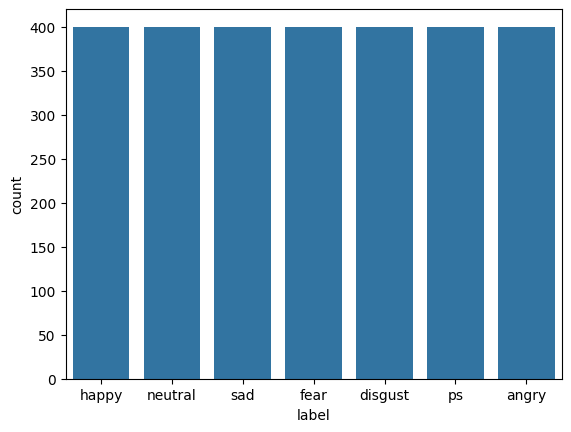

In [10]:
sns.countplot(data=df, x='label')

In [11]:
def waveplot(data, sr, emotion):
    plt.figure(figsize=(10,4))
    plt.title(emotion, size=20)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def spectogram(data, sr, emotion):
    x = librosa.stft(data)
    xdb = librosa.amplitude_to_db(abs(x))
    plt.figure(figsize=(11,4))
    plt.title(emotion, size=20)
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    plt.colorbar()

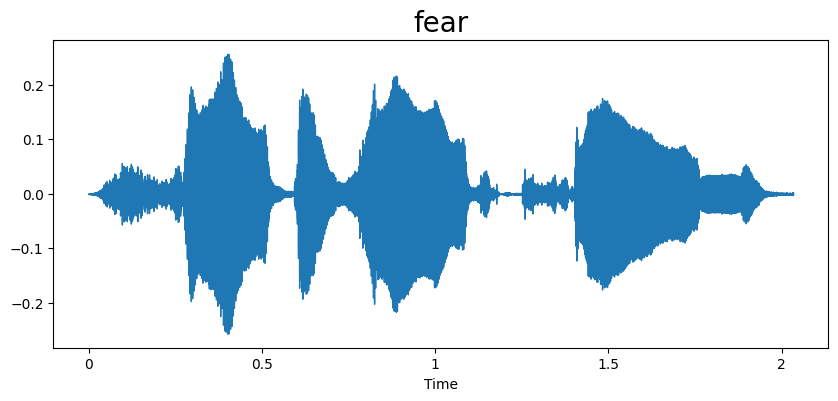

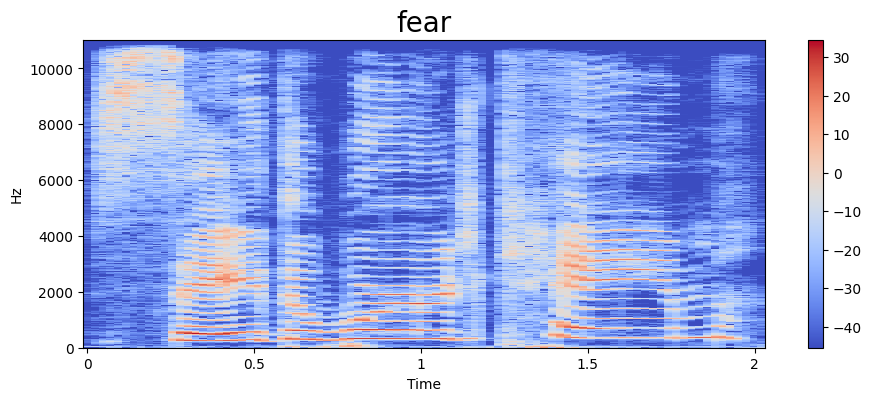

In [12]:
emotion = 'fear'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

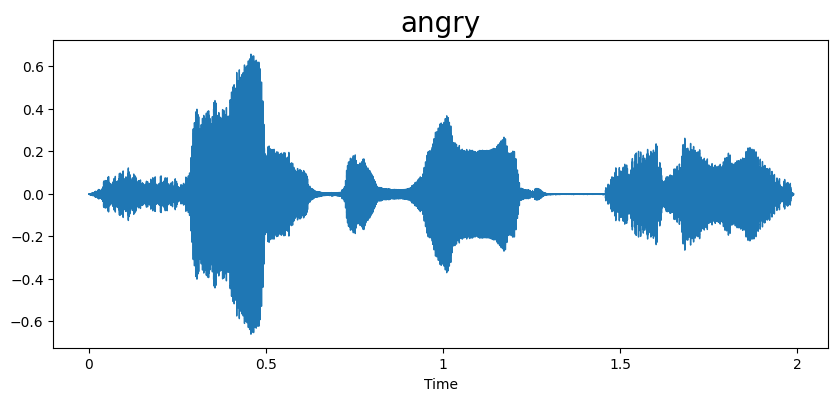

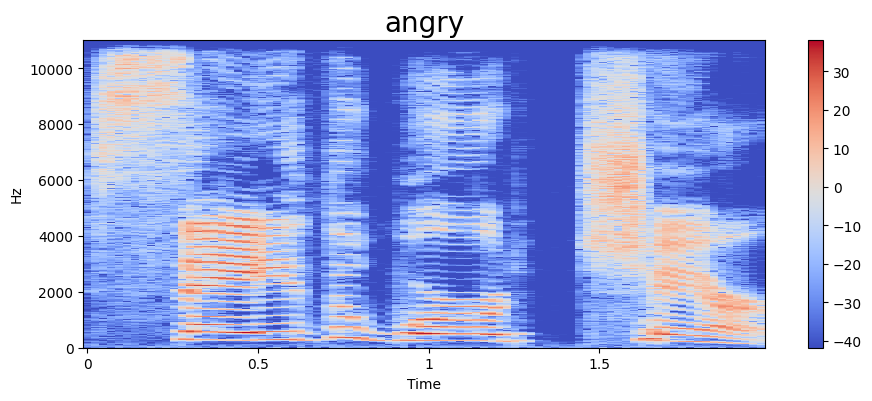

In [14]:
emotion = 'angry'
path = np.array(df['audio_paths'][df['label']==emotion])[1]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

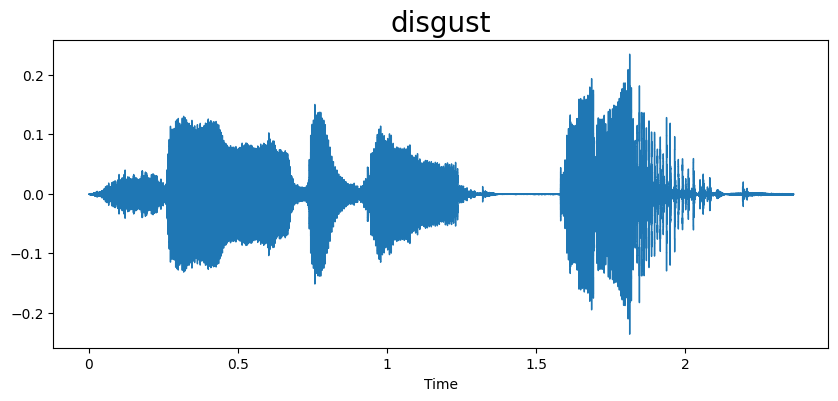

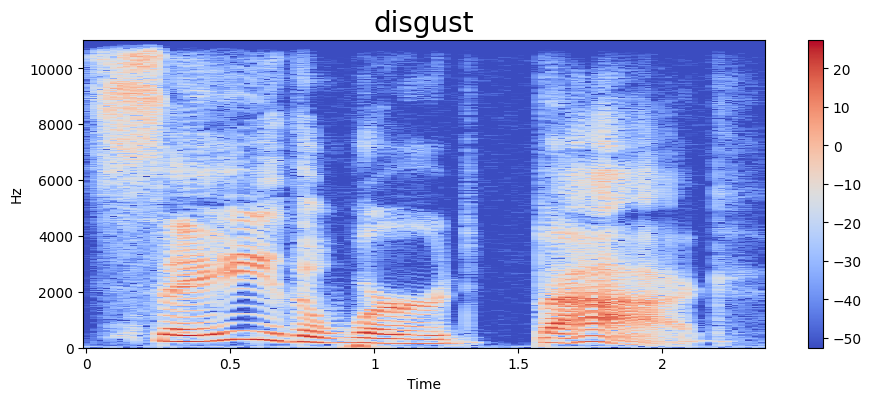

In [15]:
emotion = 'disgust'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

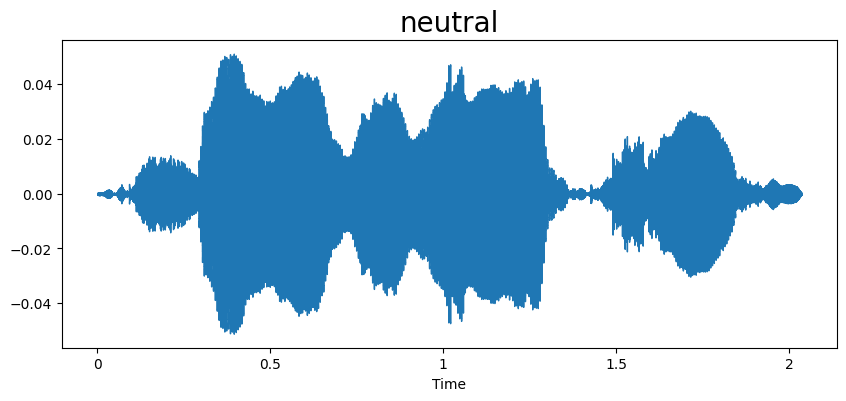

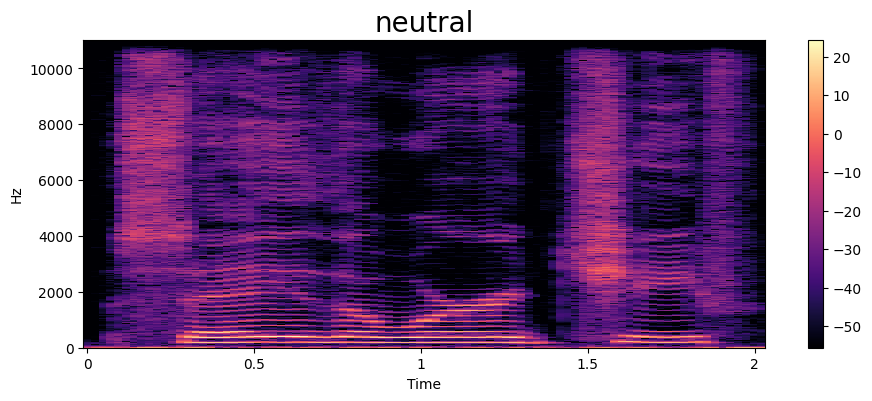

In [17]:
emotion = 'neutral'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

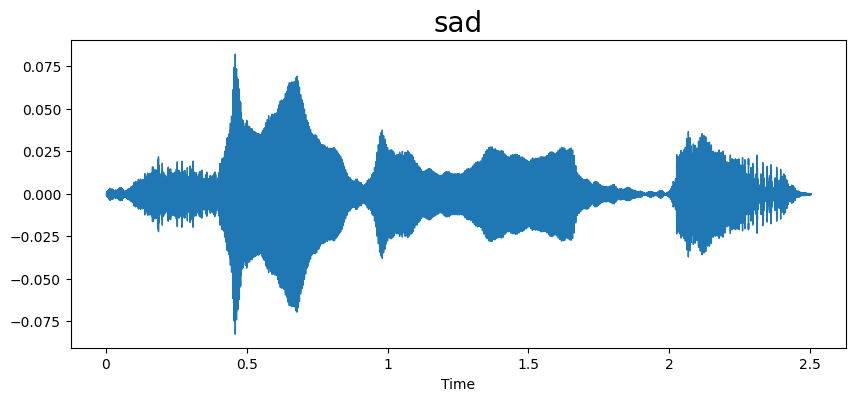

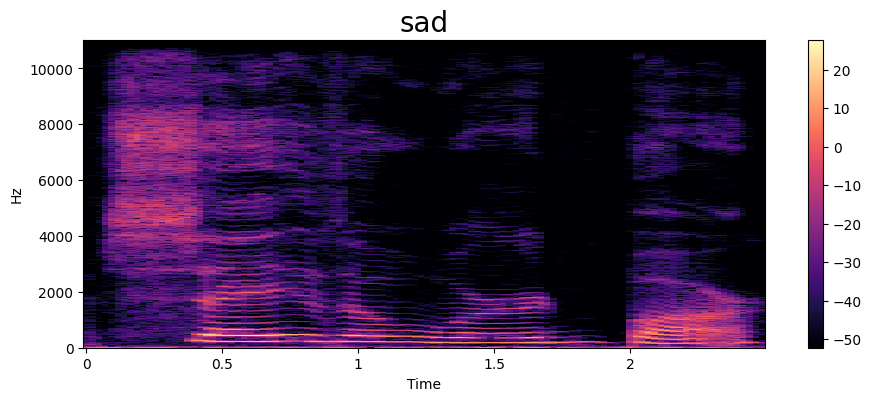

In [18]:
emotion = 'sad'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

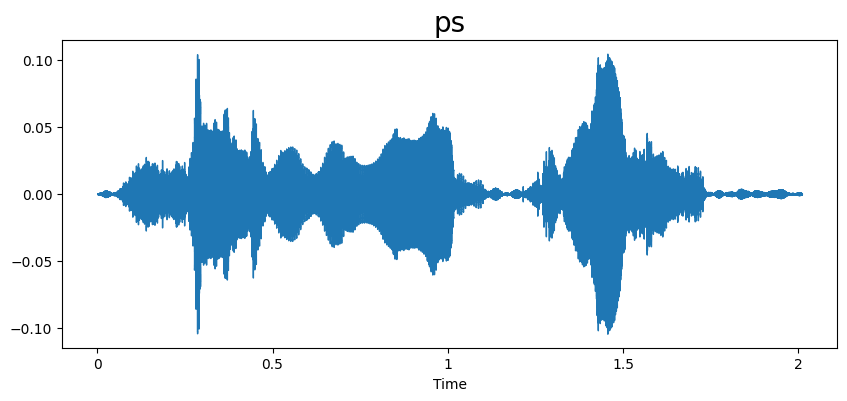

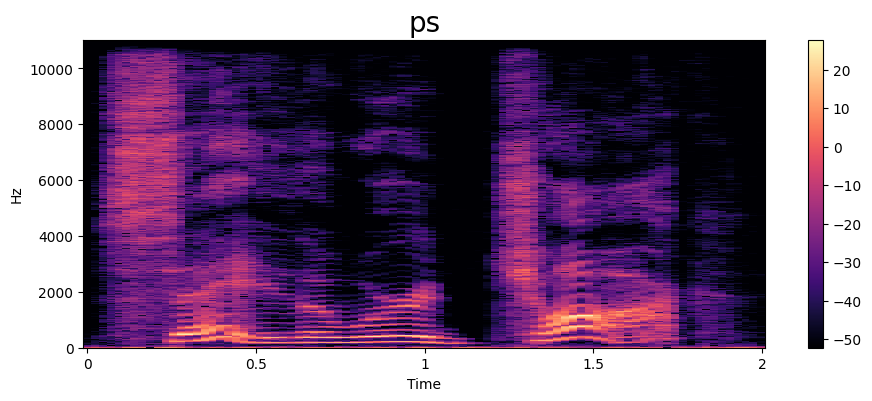

In [19]:
emotion = 'ps'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

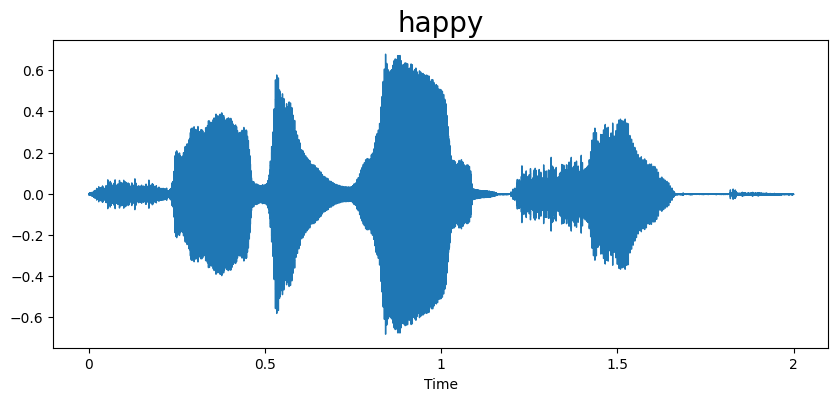

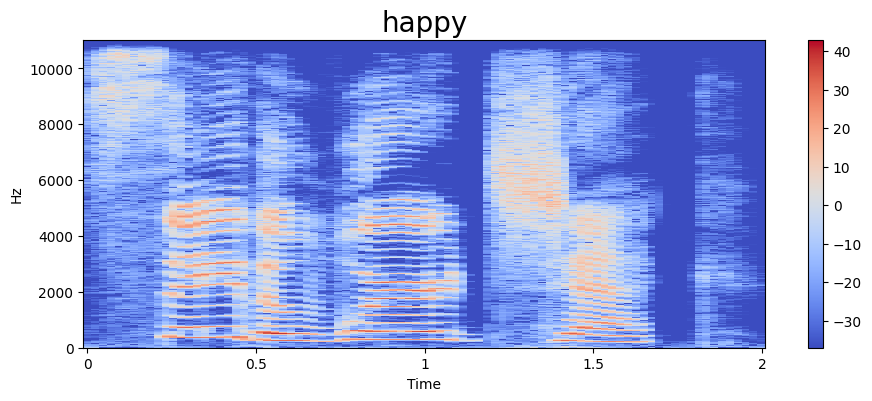

In [20]:
emotion = 'happy'
path = np.array(df['audio_paths'][df['label']==emotion])[0]
data, sampling_rate = librosa.load(path)
waveplot(data, sampling_rate, emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

Create Custom Dataset Class

In [21]:
# Convert labels to integers
label_map = {label: idx for idx, label in enumerate(df['label'].unique())}
inverse_label_map = {idx: label for label, idx in label_map.items()}

df['labels'] = df['label'].map(label_map)

df.head(2)

,audio_paths,label,labels
0,/content/drive/MyDrive/SER_yt/Dataset/TESS Tor...,happy,0
1,/content/drive/MyDrive/SER_yt/Dataset/TESS Tor...,happy,0


In [22]:
print(label_map)


{'happy': 0, 'neutral': 1, 'sad': 2, 'fear': 3, 'disgust': 4, 'ps': 5, 'angry': 6}


In [ ]:
# path = np.array(df['audio_paths'][df['labels']==2])[0]
# data, sampling_rate = librosa.load(path)
# len(data)
# sampling_rate * 2

In [23]:
class speechEmotionDataset(Dataset):
  def __init__(self, df, processor, max_length=32000):
    self.df = df
    self.processor = processor
    self.max_length = max_length

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    audio_path = self.df.iloc[idx]['audio_paths']  # Use correct column name!
    label = self.df.iloc[idx]['labels']

    # load audio
    speech, sr = librosa.load(audio_path, sr=16000)


    # pad or truncate
    if len(speech) > self.max_length:
      speech = speech[:self.max_length]
    else:
      speech = np.pad(speech, (0, self.max_length - len(speech)), 'constant')

    # process audio
    inputs = self.processor(speech, sampling_rate=16000, return_tensors='pt', padding=True, max_length=self.max_length)
    input_values = inputs.input_values.squeeze()

    return {
        'input_values': input_values,
        'labels': torch.tensor(label, dtype=torch.long)
    }


In [24]:
#split the data for train and test
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [25]:
# #initialize the processor and model
# processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')
# model = Wav2Vec2ForSequenceClassification.from_pretrained('facebook/wav2vec2-base', num_labels=7)
from transformers import Wav2Vec2Config

processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base')

# ADD THIS:
id2label = {v: k for k, v in label_map.items()}
label2id = label_map

config = Wav2Vec2Config.from_pretrained(
    "facebook/wav2vec2-base",
    num_labels=7,
    id2label=id2label,
    label2id=label2id
)

model = Wav2Vec2ForSequenceClassification.from_pretrained(
    "facebook/wav2vec2-base",
    config=config
)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
#load the dataset
train_dataset = speechEmotionDataset(train_df,processor)
test_dataset = speechEmotionDataset(test_df,processor)

In [27]:
train_dataset[0]['input_values'].size()

torch.Size([32000])

In [28]:
#create dataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

#set Training Arguments

In [29]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"  # <-- ✨ Changed from [] to "none"
)

In [30]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np

def compute_metrics(pred):
    labels = pred.label_ids
    predictions = np.argmax(pred.predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="weighted")
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }


In [31]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=processor,
    compute_metrics=compute_metrics
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.565145,1.000000,1.000000,1.000000,1.000000
2,No log,0.206807,1.000000,1.000000,1.000000,1.000000
3,No log,0.156230,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=420, training_loss=0.6377344767252604, metrics={'train_runtime': 1610.806, 'train_samples_per_second': 4.172, 'train_steps_per_second': 0.261, 'total_flos': 1.2201848064e+17, 'train_loss': 0.6377344767252604, 'epoch': 3.0})

In [32]:
results = trainer.evaluate()
print(results)

{'eval_loss': 0.15622985363006592, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 7.4611, 'eval_samples_per_second': 75.056, 'eval_steps_per_second': 4.691, 'epoch': 3.0}


In [34]:
# Save model + processor
model.save_pretrained("/content/drive/MyDrive/SER_yt/my_saved_model")
processor.save_pretrained("/content/drive/MyDrive/SER_yt/my_saved_model")

# Save label_map for future use
import pickle
with open("/content/drive/MyDrive/SER_yt/label_encoder.pkl", "wb") as f:
    pickle.dump(label_map, f)